<a href="https://colab.research.google.com/github/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN-BERT (in Pytorch and compatible with HuggingFace)

This is a Pytorch (+ **Huggingface** transformers) implementation of the GAN-BERT model from https://github.com/crux82/ganbert. While the original GAN-BERT was an extension of BERT, this implementation can be adapted to several architectures, ranging from Roberta to Albert!

**NOTE**: given that this implementation is different from the original one in Tensorflow, some results can be slighty different.


Let's GO!

Required Imports.

In [1]:
#!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
#seed_val = 42
seed_val = 4
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import json
import os
from torch.autograd import Variable

In [3]:
from utils import to_gpu, Corpus, batchify, train_ngram_lm, get_ppl, create_exp_dir
from models import Seq2Seq, MLP_D, MLP_D_local, MLP_G

In [4]:
#torch.cuda.empty_cache()

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


### Input Parameters


In [6]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 92

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 50
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
#model_name = "google/electra-base-discriminator"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
#! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
data = "../../yelp/yelp_small.csv"

label_list = ['UNK',1,2,3,4]

In [7]:
# df_yelp = pd.read_csv(data)
# df_yelp = df_yelp.set_index("Unnamed: 0")
# df = df_yelp.sample(frac=1)
# numbers=list(df['category_id'].unique())
# list_zeros = [0]*len(numbers)
# count_dictionary = dict(zip(numbers, list_zeros))

# values_array_train=[]
# values_array_test=[]
# values_array_unlabelled=[]
# for index, row in df.iterrows():
#     if count_dictionary[row['category_id']]<20:
#         count_dictionary[row['category_id']]=count_dictionary[row['category_id']]+1
#         values_array_train.append((row['Consumer_complaint_narrative'],row['category_id']))
#     elif count_dictionary[row['category_id']]<60:
#         count_dictionary[row['category_id']]=count_dictionary[row['category_id']]+1
#         values_array_test.append((row['Consumer_complaint_narrative'],row['category_id']))
#     elif count_dictionary[row['category_id']]<600:
#         count_dictionary[row['category_id']]=count_dictionary[row['category_id']]+1
#         values_array_unlabelled.append((row['Consumer_complaint_narrative'],'UNK'))

In [8]:
# #Load the examples
# labeled_examples = values_array_train
# unlabeled_examples = values_array_unlabelled
# test_examples = values_array_test

In [9]:
# df_train = pd.DataFrame(values_array_train)
# print(df_train[1].value_counts())
# df_train.head()

In [10]:
# df_test = pd.DataFrame(values_array_test)
# print(df_test[1].value_counts())
# df_test.head()

In [11]:
# df_unlabelled = pd.DataFrame(values_array_unlabelled)
# print(df_unlabelled[1].value_counts())
# df_unlabelled.head()

In [12]:
df_train_l=pd.read_csv("../../AGNews/assigned/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("../../AGNews/assigned/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("../../AGNews/assigned/u.csv", index_col="Unnamed: 0")
df_train_u=pd.read_csv("../../AGNews/assigned/train_u.csv", index_col="Unnamed: 0")
df_test_u=pd.read_csv("../../AGNews/assigned/test_u.csv", index_col="Unnamed: 0")

In [13]:
values_array_train=list(df_train_l.to_records(index=False))
values_array_test=list(df_test_l.to_records(index=False))
values_array_unlabelled=list(df_u.to_records(index=False))

In [14]:
print(df_test_u['0'].size)

10000


In [15]:
#Load the examples
labeled_examples = values_array_train
unlabeled_examples = values_array_unlabelled
test_examples = values_array_test

Load the Tranformer Model

In [16]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

Function required to load the dataset

**Load** the input QC dataset (fine-grained)

Functions required to convert examples into Dataloader

In [17]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
def generate_data_fake(input_examples):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []

  # Tokenization 
  for text in input_examples:
    encoded_sent = tokenizer.encode(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)

  # Building the DataLoader
  return input_ids, input_mask_array # Trains with this batch size.


Convert the input examples into DataLoader

In [19]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [20]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
# class Generator(nn.Module):
#     def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
#         super(Generator, self).__init__()
#         layers = []
#         hidden_sizes = [noise_size] + hidden_sizes
#         for i in range(len(hidden_sizes)-1):
#             layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

#         layers.append(nn.Linear(hidden_sizes[-1],output_size))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, noise):
#         output_rep = self.layers(noise)
#         return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

We instantiate the Discriminator and Generator

In [21]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

Let's go with the training procedure

In [22]:
#data_path="data/MS_COCO"
data_path="../../AGNews/unlabelled"
save="./results/AGNews_results"
maxlen=64
batch_size=24
eval_batch_size = 32
noise_seq_length = 15
add_noise=True #what does this do? - question applies to most parameters
emsize=512
nhidden=512
nlayers=2
nheads=4
nff=1024
aehidden=56
noise_r=0.05
hidden_init=True
dropout=0.3
gpu=True
z_size=100
arch_g='300-300'
gan_g_activation=True
arch_d='300-300'
gan_d_local=True
gan_d_local_windowsize=3
arch_d_local='300-300'
lr_ae=0.12
lr_gan_e=1e-04
beta1=0.5
lr_gan_g=4e-04
lr_gan_d=1e-04
epochs=1
sample=True
clip=1
log_interval=100
gan_lambda=0.1
niters_gan_d=1
niters_gan_g=1
niters_gan_ae=1
niters_gan_dec=1
niters_gan_schedule=''
niters_ae=1
gan_type='kl'
enhance_dec=True
gan_gp_lambda=1
vocab_size=0
lowercase=True

In [23]:
corpus = Corpus(data_path,
                maxlen=maxlen,
                vocab_size=vocab_size,
                lowercase=lowercase)

ntokens = len(corpus.dictionary.word2idx)
print("Vocabulary Size: {}".format(ntokens))
ntokens = ntokens

autoencoder = Seq2Seq(add_noise=add_noise,
                      emsize=emsize,
                      nhidden=nhidden,
                      ntokens=ntokens,
                      nlayers=nlayers,
                      nheads=nheads,
                      nff=nff,
                      aehidden=aehidden,
                      noise_r=noise_r,
                      hidden_init=hidden_init,
                      dropout=dropout,
                      gpu=True)
nlatent = aehidden * (maxlen+1)
gan_gen = MLP_G(ninput=z_size, noutput=nlatent, layers=arch_g, gan_g_activation=gan_g_activation)
gan_disc = MLP_D(ninput=nlatent, noutput=1, layers=arch_d)
gan_disc_local = MLP_D_local(ninput=gan_d_local_windowsize * aehidden, noutput=1, layers=arch_d_local)

original vocab 73560; pruned to 73564
Number of sentences dropped from ../../yelp/unlabelled_small/train.txt: 5 out of 60000 total
Number of sentences dropped from ../../yelp/unlabelled_small/test.txt: 0 out of 5000 total
Vocabulary Size: 73564


In [24]:
def load_models():
    #model_args = json.load(open(os.path.join("./results/AGNews_results_small/options.json"), 'r'))
    word2idx = json.load(open(os.path.join("./results/AGNews_results_small/vocab.json"), 'r'))
    idx2word = {v: k for k, v in word2idx.items()}

    print('Loading models from {}'.format("./results/AGNews_results"))
    loaded = torch.load(os.path.join("./results/AGNews_results", "model.pt"))
    autoencoder.load_state_dict(loaded.get('ae'))
    gan_gen.load_state_dict(loaded.get('gan_g'))
    gan_disc.load_state_dict(loaded.get('gan_d'))
    gan_disc_local.load_state_dict(loaded.get('gan_d_local'))
    #return model_args, idx2word, autoencoder, gan_gen, gan_disc
    return model_args, idx2word, autoencoder, gan_gen, gan_disc

In [25]:
def gen_fixed_noise_new(noise):
    gan_gen.eval()
    autoencoder.eval()

    fake_hidden = gan_gen(noise)
    max_indices = autoencoder.generate(fake_hidden, maxlen, sample=sample)
    
    sent_list = []
    
    #with open(to_save, "w") as f:
    max_indices = max_indices.data.cpu().numpy()
    for idx in max_indices:
        # generated sentence
        words = [corpus.dictionary.idx2word[x] for x in idx]
        # truncate sentences to first occurrence of <eos>
        truncated_sent = []
        for w in words:
            if w != '<eos>':
                truncated_sent.append(w)
            else:
                break
        chars = " ".join(truncated_sent)
        #f.write(chars + '\n')
        sent_list.append(chars)
    #print(sent_list)
    return sent_list

In [26]:
#model_args, idx2word, autoencoder, gan_gen, gan_disc,gan_disc_local = load_models()
#model_args, idx2word, autoencoder, gan_gen, gan_disc = load_models()
idx2word, autoencoder, gan_gen, gan_disc = load_models()
autoencoder = autoencoder.to(device)
gan_gen = gan_gen.to(device)
gan_disc = gan_disc.to(device)
#gan_disc_local = gan_disc_local.to(device)
print("Load Ckpt Done")

Loading models from ./results/yelp_results_small
Load Ckpt Done


In [32]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    #generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs.last_hidden_state[:,0,:] 
        #hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        fixed_noise = Variable(torch.ones(batch_size, 100).normal_(0, 1).to(device))
        fake_sentences = gen_fixed_noise_new(fixed_noise)
        
        b_input_ids_fake, b_input_mask_fake = generate_data_fake(fake_sentences)
        model_outputs_fake = transformer(b_input_ids_fake, attention_mask=b_input_mask_fake)
        hidden_states_fake = model_outputs_fake.last_hidden_state[:,0,:] 
        #hidden_states_fake = model_outputs_fake[-1]
        
        #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        #gen_rep = generator(noise)
        #print("Length of generator output {}".format(len(gen_rep)))
        #print("Length of single generator output {}".format(len(gen_rep[0])))

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, hidden_states_fake], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        #gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        #gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()
        
        _, preds = torch.max(logits[:,0:-1], 1)
        #print(preds)

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          #scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    #generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs.last_hidden_state[:,0,:] 
            #hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        
        #print(preds)

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    accuracy_array.append(test_accuracy)
    
    


======== Epoch 1 / 50 ========
Training...
  Batch    10  of     60.    Elapsed: 0:00:11.
  Batch    20  of     60.    Elapsed: 0:00:22.
  Batch    30  of     60.    Elapsed: 0:00:33.
  Batch    40  of     60.    Elapsed: 0:00:44.
  Batch    50  of     60.    Elapsed: 0:00:56.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.717
  Training epcoh took: 0:01:07

Running Test...
  Accuracy: 0.510
  Test Loss: 3.310
  Test took: 0:00:00

======== Epoch 2 / 50 ========
Training...
  Batch    10  of     60.    Elapsed: 0:00:11.
  Batch    20  of     60.    Elapsed: 0:00:22.
  Batch    30  of     60.    Elapsed: 0:00:33.
  Batch    40  of     60.    Elapsed: 0:00:45.
  Batch    50  of     60.    Elapsed: 0:00:56.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.715
  Training epcoh took: 0:01:07

Running Test...
  Accuracy: 0.505
  Test Loss: 3.274
  Test took: 0:00:00

======== Epoch 3 / 50 ========
Training...
  Batch    1

KeyboardInterrupt: 

In [28]:
for stat in training_stats:
  print(stat)

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

{'epoch': 1, 'Training Loss generator': 0.3699815367658933, 'Training Loss discriminator': 3.240087612469991, 'Valid. Loss': 1.7102851867675781, 'Valid. Accur.': 0.245, 'Training Time': '0:01:07', 'Test Time': '0:00:00'}
{'epoch': 2, 'Training Loss generator': 0.6538894613583882, 'Training Loss discriminator': 2.5966588457425437, 'Valid. Loss': 1.6519674062728882, 'Valid. Accur.': 0.32, 'Training Time': '0:01:07', 'Test Time': '0:00:00'}
{'epoch': 3, 'Training Loss generator': 0.6786152799924214, 'Training Loss discriminator': 2.4056735237439475, 'Valid. Loss': 1.5744330883026123, 'Valid. Accur.': 0.37, 'Training Time': '0:01:07', 'Test Time': '0:00:00'}
{'epoch': 4, 'Training Loss generator': 0.6943467686573664, 'Training Loss discriminator': 2.196653091907501, 'Valid. Loss': 1.4607852697372437, 'Valid. Accur.': 0.43, 'Training Time': '0:01:07', 'Test Time': '0:00:00'}
{'epoch': 5, 'Training Loss generator': 0.699587286512057, 'Training Loss discriminator': 1.9544970095157623, 'Valid.

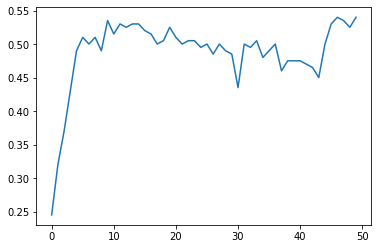

In [29]:
plt.plot(accuracy_array)

In [30]:
print(max(accuracy_array))

0.54


In [31]:
print(accuracy_array[-1])

0.54
